In [303]:
from keras.datasets import mnist
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import MDS, smacof
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly.express as px

In [4]:
iris = sns.load_dataset("iris")

In [208]:
iris_data = iris.iloc[:,0:4].values
iris_labels = iris.iloc[:,4].values

iris_data = StandardScaler().fit_transform(iris_data)

In [56]:
mnist = mnist.load_data()

11501568/11490434 [==============================] - 12s 1us/step


In [103]:
mnist_data_train = mnist_data[0]
mnist_data = mnist_data_train[0]
mnist_labels = mnist_data_train[1]

In [145]:
sampled_indices = pd.DataFrame(mnist_labels).groupby(0).sample(n=1000).index.values

In [197]:
mnist_data = mnist_data[sampled_indices].reshape(10000,-1)
mnist_labels = mnist_labels[sampled_indices]

In [272]:
np.save("mnist_data.npy",mnist_data)
np.save("mnist_labels.npy",mnist_labels)

In [182]:
sns.set_context("talk")

In [289]:
def do_mds(data, labels, n_components = 2,metric=True,n_init=4,max_iter=1000,random_state=3000,
          dissimilarity="euclidean"):
    mds=MDS(n_components=n_components, 
          metric=metric, 
          n_init=n_init, 
          max_iter=max_iter, 
          verbose=0, 
          eps=0.00001, 
          n_jobs=None, 
          random_state = random_state,
          dissimilarity=dissimilarity)

    data_transformed = mds.fit_transform(data)
    stress = round(mds.stress_,0)
    print('Iterations: ', mds.n_iter_)
    print('Stress: ', stress)

    columns = ["MDS" + str(i) for i in range(1,n_components + 1)]
    toplot = pd.DataFrame(data_transformed,columns=columns)
    toplot["label"] = labels
    
    return toplot, stress

def plot_mds(data,title,ax=None):
    legend = None
    if ax is None:
        fig = plt.figure(figsize=(20, 9))
        ax = fig.add_subplot(1,1,1)
        legend = "auto"
    ax.set_title(title)
    sns.scatterplot(x="MDS1",y="MDS2",hue="label",data=data,alpha = 0.6,s=300,ax=ax,legend=legend)
    
    
def plot_mds3d(data):
    plot = px.scatter_3d(df, x='MDS1', y='MDS2', z='MDS3',
              color='label',title="3 dimensional MDS (Euclidian distances)")
    return plot

scikit-learn MDS implementuotas naudojant **SMACOF** algoritmą.

Yra daug būdų minimizuoti stress funkciją (pvz. naudojant gradientų nusileidimą), tačiau rastas geresnis (pagal konvergavimo garantijas) SMACOF *iterative majorization* metodas, kuris paremtas pagalbinės funkcijos, vadinamos *majorizing function*, minizavimu.

Majorizing function yra tokia funkcija, kad:

$g(x)≥f(x) \ \  \forall  x\in X$

$g(y)=f(y)$

Pavyzdžiui:

<img src="loog-1.png" alt="majorizing function" width="500"/>

 
Stress išskaidomas ir randama, kad jo *majorizing function* yra kvadratinė funkcija $\tau (X,Z)$:




Paaiškėja ir akronimo SMACOF reikšmė ("Scaling by MAjorizing a COmplicated Function").


Ši kvadratinė funkcija minimizuojama naudojant specifinę *Guttman transformaciją*, kurios rezultatas yra tuo metu esamos iteracijos taškų išsidėstymas.
 
 
Gaunama bendra MDS schema implementuota scikit-learn:
- Pradinė taškų konfiguracija (atsitiktinė arba ne)
- Apskaičiuojamas Stress
- Apskaičiuojama Guttman transformacija
- 2 ir 3 žingsniai kartojami iki konvergavimo (iki tol kol per vieną iteraciją Stress sumažėja mažiau negu iš anksto nustatyta riba)

Iterations:  76
Stress:  235.0


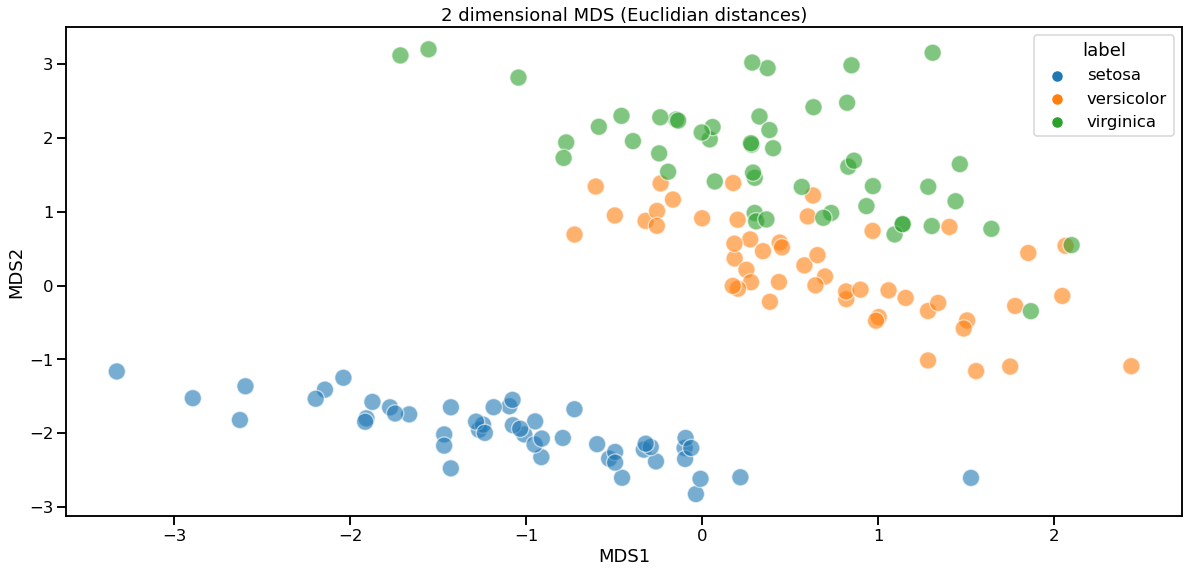

In [265]:
# vizualizacija sumazinus dimensija iki 2
df , _ = do_mds(iris_data,iris_labels)

plot_mds(df,"2 dimensional MDS (Euclidian distances)")

In [251]:
def stress_plot(data,labels):
    stress = []
    n_dimensions = range(1,data.shape[1])
    for i in n_dimensions:
        _ , stress_value = do_mds(data,labels,n_components=i)
        stress.append(stress_value)

    ax = sns.lineplot(x=n_dimensions,y=stress)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("n_components")
    ax.set_ylabel("stress")
    ax.set_title("Stress by remaining components")

Iterations:  23
Stress:  10076.0
Iterations:  76
Stress:  235.0
Iterations:  241
Stress:  5.0


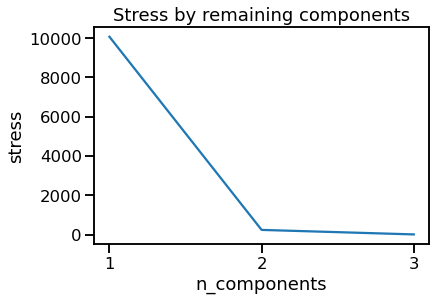

In [252]:
# matome, kad stress stiprai dideja tik jeigu noretume sumazinti dim iki 1
stress_plot(iris_data,iris_labels)

In [290]:
# vizualizacija sumazinus dimensija iki 3
df , _ = do_mds(iris_data,iris_labels,n_components=3)

plot_mds3d(df)

Iterations:  241
Stress:  5.0


Iterations:  76
Stress:  235.0
Iterations:  93
Stress:  1079.0
Iterations:  196
Stress:  3327.0
Iterations:  122
Stress:  505.0
Iterations:  1000
Stress:  1428.0
Iterations:  195
Stress:  5531.0


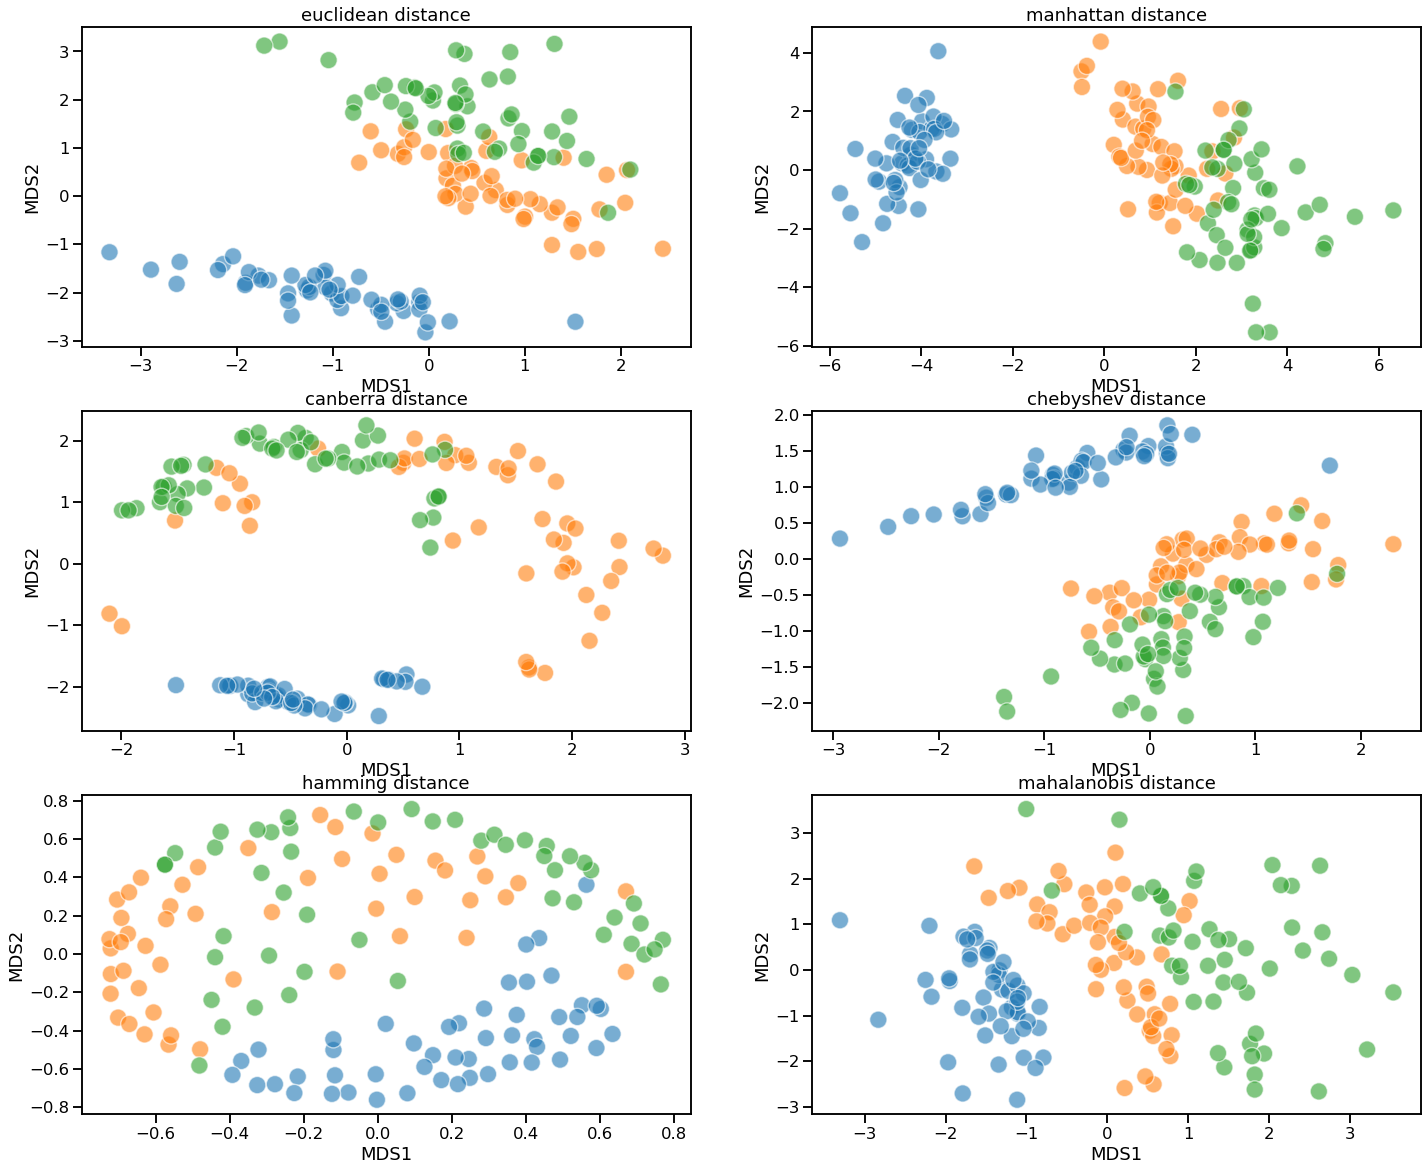

In [266]:
# kokie rezultatai butu gaunami jeigu butu naudojami kitokios atstumu metrikos
dist_types = ['euclidean','manhattan', 'canberra', 'chebyshev', 'hamming', 'mahalanobis']

fig, ax = plt.subplots(3,2,figsize=(24, 20))
ax = ax.flatten()
              
for i,j in enumerate(dist_types):
    dist = pairwise_distances(iris_data, metric=j)
    df, _ = do_mds(dist,iris_labels,dissimilarity="precomputed")
    plot_mds(df,j + " distance",ax[i])      

Iterations:  3
Stress:  503.0


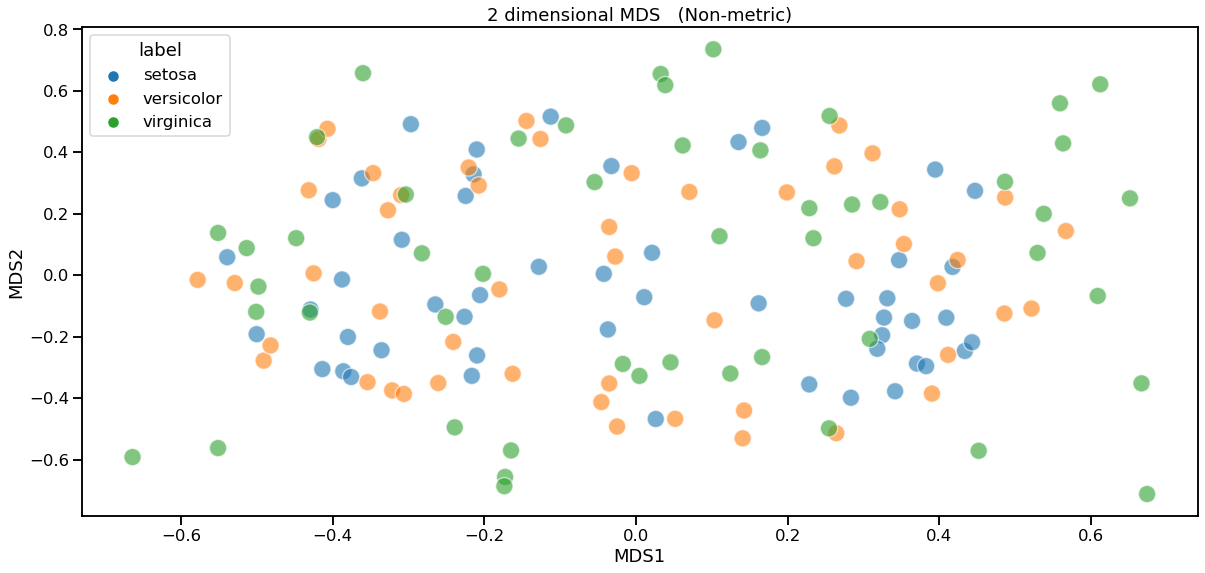

In [237]:
# nemetrikiniu MDS siuo atveju rezultatai daug prastesni
df , _ = do_mds(iris_data,iris_labels,metric=False)

plot_mds(df,"(Non-metric)")

Iterations:  50
Stress:  270.0
Iterations:  50
Stress:  911.0
Iterations:  50
Stress:  246.0


C:\Users\dovyd\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:240: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 8



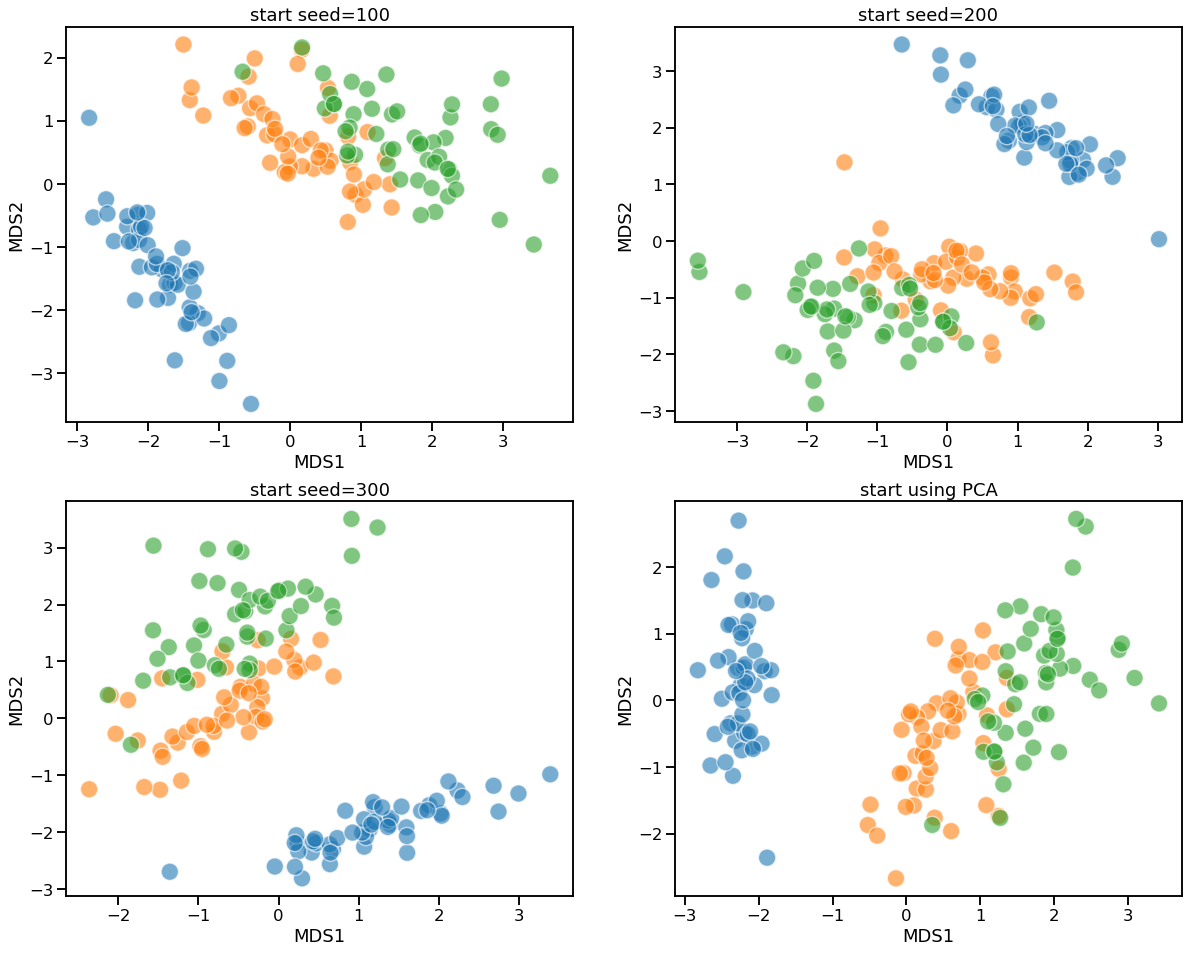

In [317]:
# matome, kad pradinis tasku issidestymas duoda skirtingus galutinius rezultatus
# galima pradeti su atsitiktiniu tasku isidestymu arba su neatsitiktiniu (pvz. gautu naudojant PCA)

start_seeds = [100,200,300]

fig, ax = plt.subplots(2,2,figsize=(20, 16))
ax = ax.flatten()
              
for i,j in enumerate(start_seeds):
    df, _ = do_mds(iris_data,iris_labels,random_state=j,max_iter = 50)
    plot_mds(df,"start seed=" + str(j),ax[i])     
    
    
pca = PCA(n_components = 2)
iris_pca = pca.fit_transform(iris_data)
dist = pairwise_distances(iris_data,metric="euclidean")
result, stress = smacof(dist, n_components = 2, init=iris_pca)
df = pd.DataFrame(result,columns=["MDS1","MDS2"])
df["label"] = iris_labels
plot_mds(df,"start using PCA",ax[-1]) 

Iterations:  1
Stress:  64335.0
Iterations:  2
Stress:  25912.0
Iterations:  3
Stress:  21139.0
Iterations:  5
Stress:  13923.0
Iterations:  8
Stress:  5197.0
Iterations:  13
Stress:  2207.0
Iterations:  21
Stress:  1288.0
Iterations:  34
Stress:  541.0
Iterations:  55
Stress:  241.0


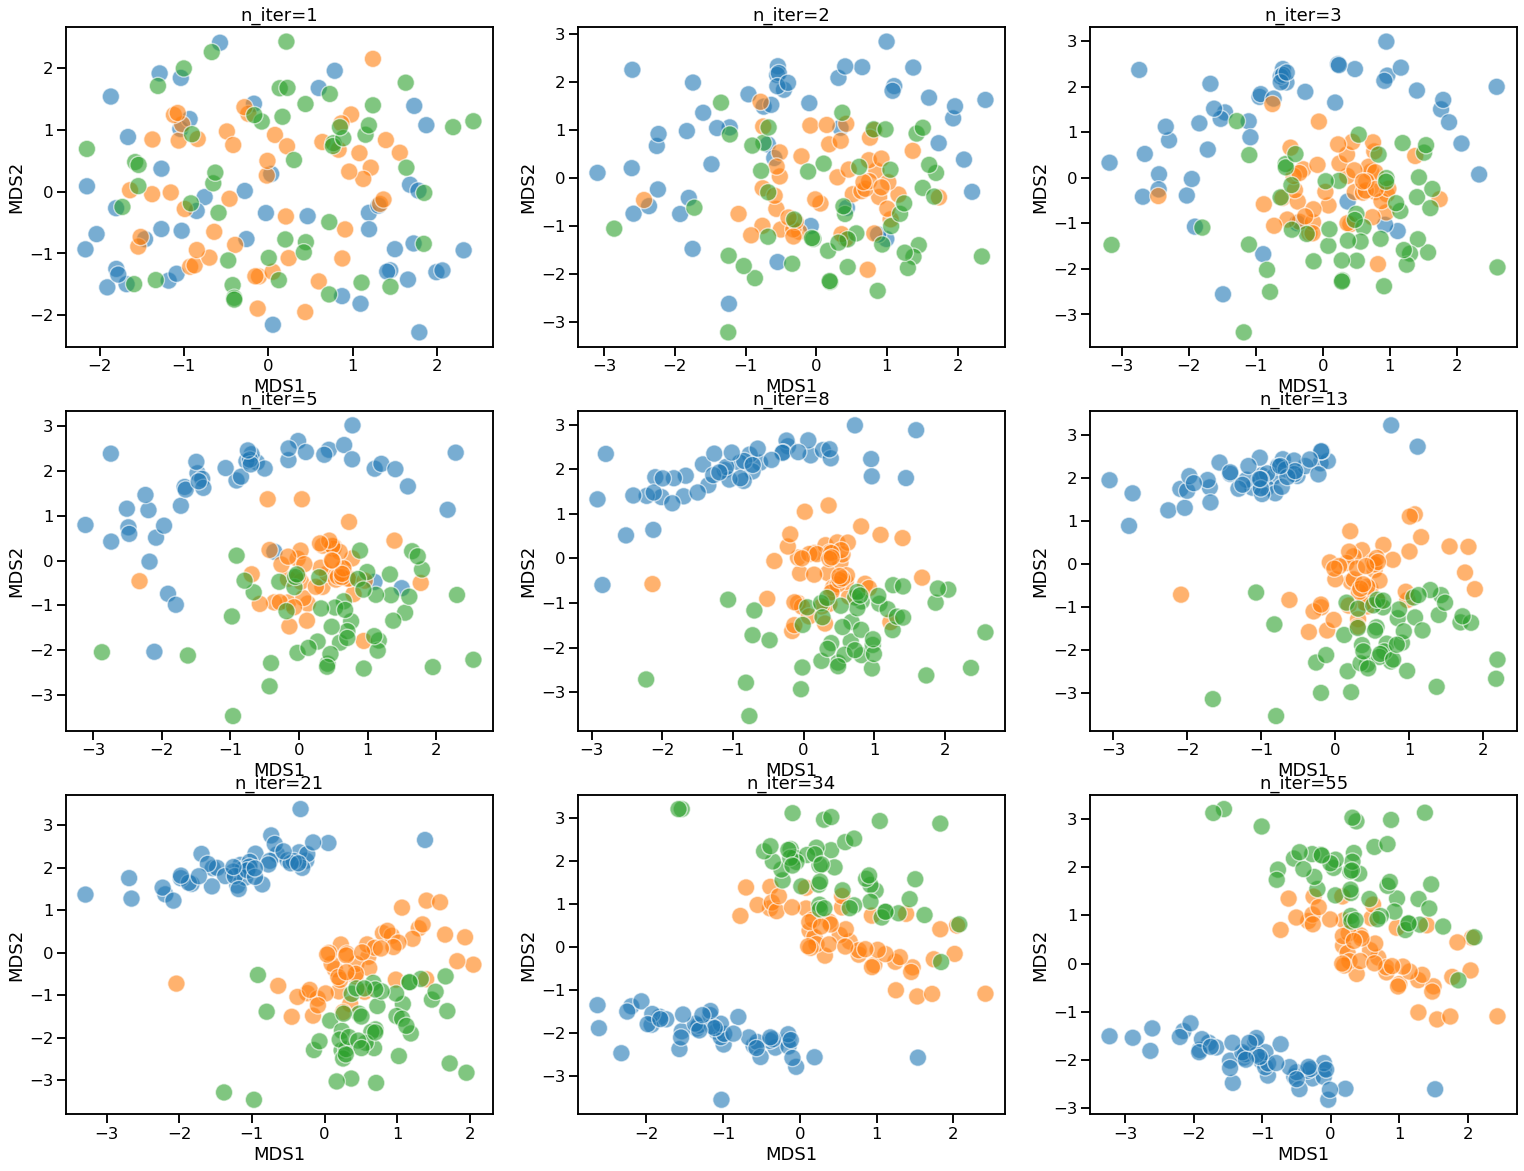

In [270]:
# matoma, kaip SMOCAF algoritmas perdelioja tasku lokacijas didejant iteracijoms
max_iter = [1,2,3,5,8,13,21,34,55]

fig, ax = plt.subplots(3,3,figsize=(26, 20))
ax = ax.flatten()
              
    
for i,j in enumerate(max_iter):
    df, _ = do_mds(iris_data,iris_labels,max_iter = j)
    plot_mds(df,"n_iter=" + str(j),ax[i])      

Iterations:  154
Stress:  1417.0
Iterations:  76
Stress:  235.0
Iterations:  76
Stress:  235.0
Iterations:  76
Stress:  235.0


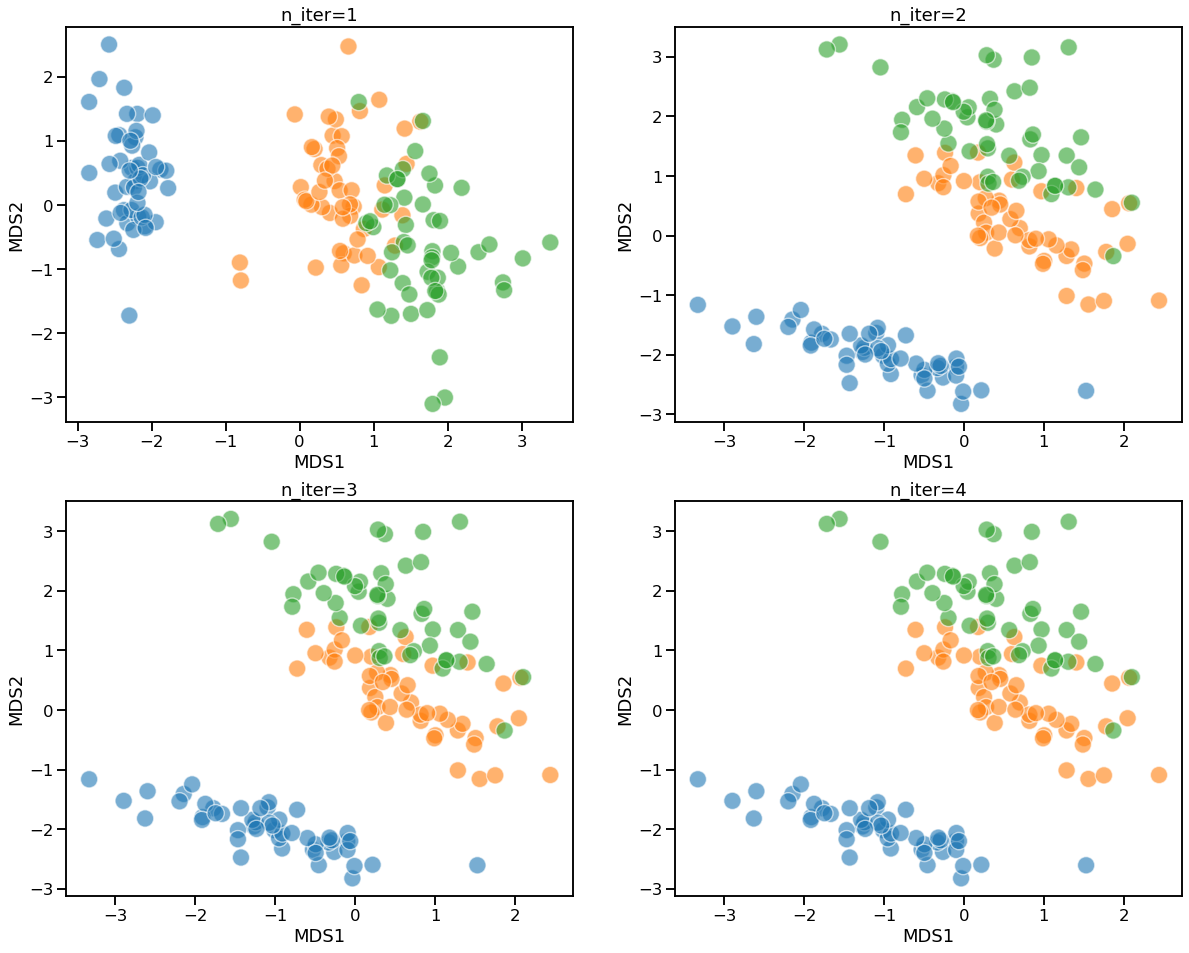

In [292]:
# n_init nustato kiek kartu atlikti SMACOF algoritma -> grazinamas tik geriausias rezultatas
# matoma, kad naudojant tik viena iteracija siuo atveju randamas tik lokalus minimumas 

n_init = [1,2,3,4]

fig, ax = plt.subplots(2,2,figsize=(20, 16))
ax = ax.flatten()
              
    
for i,j in enumerate(n_init):
    df, _ = do_mds(iris_data,iris_labels,n_init=j)
    plot_mds(df,"n_iter=" + str(j),ax[i])      